Here we see how to use tensorboard using the same MLP example we used earlier



In [1]:
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torch.nn.functional as F

from torch.utils.tensorboard import SummaryWriter

In [2]:
writer = SummaryWriter("runs/mnist")

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
input_size = 784 ## input image is 28*28 grayscale 1 channel
hidden_size = 100
num_classes = 10 ## digits 0-9


In [5]:
num_epochs = 2
learning_rate = 0.001
batch_size = 100

## loading data , use dataset and dataloader

### uses MNIST dadtaset in torchvison.datasets, applies ToTensor() transforms

In [6]:
train_dataset = torchvision.datasets.MNIST(root='./data/', 
                                           train=True, transform=transforms.ToTensor(),download=True)

In [7]:
test_dataset = torchvision.datasets.MNIST(root='./data/', 
                                           train=False, transform=transforms.ToTensor(),download=True)

In [8]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

In [9]:
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

## lets plot the first 6 samples

In [10]:
examples = iter(train_loader)
samples, labels = next(examples)

In [ ]:
samples.shape

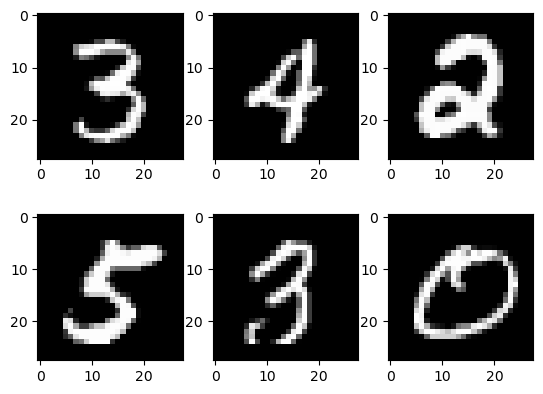

In [11]:
for i in range(0, 6):
    plt.subplot(2,3,i+1)
    plt.imshow(samples[i][0], cmap='gray') ## first channel - show in gray color
    
##plt.show()
img_grid = torchvision.utils.make_grid(samples)
writer.add_image('mnist_images', img_grid)
writer.close()
    

## To view images in tensorboard, go to localhost:6006 where tensorboard is running and check it out

## Define the model

In [12]:
class NeuralNet(nn.Module):
    
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        
        ## first input to hidden layer
        self.lin1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        
        ## second layer - hidden layer to output
        self.lin2 = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        
        out = self.lin1(x)
        out = self.relu(out)
        out = self.lin2(out) ## This gives num_classes output logits. Since we are going to use nn.CrossEntropy, no need for softmax, that is internally applied
        return out

In [13]:
model = NeuralNet(input_size, hidden_size, num_classes).to(device)

## Loss and optimizer

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

## log model onto tensorboard to view

## To view model in tensorboard, go to localhost:6006 where tensorboard is running and check it out. go to graphs

In [ ]:
samples.shape

In [15]:
writer.add_graph(model, samples.reshape(-1, 28*28)) ## reshape same way you do in training code
writer.close()

## Training loop

In [16]:
n_total_steps_per_epoch = len(train_loader)  ## no of steps / epoch (total no of samples/batch size)

In [ ]:
n_total_steps_per_epoch

In [17]:
running_loss, running_correct = 0.0, 0

In [18]:
for epoch in range(num_epochs):
    for i , (images, labels) in enumerate(train_loader):
        ## images need to be reshaped from n_samples,1,28,28 to n_samples, 784
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        
        ## forward
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        ## backward
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        running_loss = running_loss + loss.item()
        _, predicted = torch.max(outputs.data, 1 ) ## Why outputs.data instead of outputs ?
        running_correct = running_correct + (predicted==labels).sum().item()
        
        
        
        ##print
        if (i+1)%100==0:
            print(f'epoch : {epoch + 1}/{num_epochs}, step : {i+1/n_total_steps_per_epoch}, loss : {loss.item():.4f} ')
            writer.add_scalar('training_loss', running_loss/100, epoch*n_total_steps_per_epoch + i)
            writer.add_scalar('accuracy', running_correct/100, epoch*n_total_steps_per_epoch + i)
            running_loss = 0.0
            running_correct = 0 ## resetting to 0 once 100 steps are done
            ## we report average loss and correct per 100 steps
            

        

epoch : 1/2, step : 99.00166666666667, loss : 0.4431 
epoch : 1/2, step : 199.00166666666667, loss : 0.4547 
epoch : 1/2, step : 299.00166666666667, loss : 0.3909 
epoch : 1/2, step : 399.00166666666667, loss : 0.2193 
epoch : 1/2, step : 499.00166666666667, loss : 0.3497 
epoch : 1/2, step : 599.0016666666667, loss : 0.2417 
epoch : 2/2, step : 99.00166666666667, loss : 0.1674 
epoch : 2/2, step : 199.00166666666667, loss : 0.1965 
epoch : 2/2, step : 299.00166666666667, loss : 0.1439 
epoch : 2/2, step : 399.00166666666667, loss : 0.1575 
epoch : 2/2, step : 499.00166666666667, loss : 0.1673 
epoch : 2/2, step : 599.0016666666667, loss : 0.1473 


## To view loss and accuracy in tensorboard, go to localhost:6006 where tensorboard is running and check it out. go to scalar

## testing

In [20]:
labels_all = []
preds = []
with torch.no_grad():
    n_samples = 0
    n_correct = 0
    for images, labels in test_loader:
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predictions = torch.max(outputs,1) ## predictions is the index/label
        n_samples = n_samples + labels.shape[0]
        n_correct = n_correct + (predictions==labels).sum().item()
        
        class_predictions = [F.softmax(output, dim=0) for output in outputs]
        preds.append(class_predictions)
        labels_all.append(labels)
    
    
    
    labels_all = torch.cat(labels_all) ##  10000*1 shape concatenates all elements of list along 1 dim into 1-D tensor
    preds = torch.cat([torch.stack(batch) for batch in preds]) ## 10000*10 shape
    
    
    
    
    acc = 100.0 * n_correct/n_samples
    
    print(f'accuracy = {acc}')
    classes = range(10) ## class lavels from 0 to 9
    
    for i in classes:
        labels_i = labels_all == i
        preds_i = preds[:,i] ## probabilities of class i
        writer.add_pr_curve(str(i), labels_i, preds_i, global_step=0)
        
    
    

accuracy = 95.22


In [21]:
preds

tensor([[5.4466e-05, 1.0275e-07, 1.9644e-03,  ..., 9.9576e-01, 1.3304e-05,
         3.5557e-05],
        [1.8170e-04, 1.9332e-04, 9.8473e-01,  ..., 1.4430e-10, 2.2990e-04,
         1.1196e-09],
        [4.2302e-05, 9.8178e-01, 7.0914e-03,  ..., 2.9517e-03, 3.9346e-03,
         1.4371e-04],
        ...,
        [2.0584e-07, 4.4061e-08, 1.5111e-06,  ..., 1.0396e-04, 1.1346e-03,
         3.7742e-03],
        [2.7851e-05, 1.4592e-06, 2.7937e-06,  ..., 2.2053e-07, 3.1732e-03,
         2.2717e-07],
        [3.2110e-05, 6.7511e-09, 2.9563e-05,  ..., 9.4348e-09, 6.9107e-08,
         2.3601e-08]])

## To view PR curve in tensorboard, go to localhost:6006 where tensorboard is running and check it out. go to pr_curves

## References

1) https://www.youtube.com/watch?v=VJW9wU-1n18&list=PLqnslRFeH2UrcDBWF5mfPGpqQDSta6VK4&index=16